In [90]:
# Basic initialization
%matplotlib inline
import math
import numpy as np
from scipy.linalg import cholesky
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import qiskit
from qiskit import Aer, execute
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile
import sys
import os

sys.path.append("/Users/bpnachman/Desktop/dl/lattice_qft")
print(sys.path)

from lattice_qft.core import lattice as lattice_cf
#from lattice_qft.core import settings
from lattice_qft.Scalar_Field_Theory import basic_operator_implementations as basic_op_cf
from lattice_qft.Scalar_Field_Theory import lattice_sft

import itertools

['/Users/bpnachman/Desktop/dl/lattice_qft/lattice_qft/examples', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python311.zip', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/lib-dynload', '', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/site-packages', '/Users/bpnachman/Desktop/dl/lattice_qft', '/Users/bpnachman/Desktop/dl/lattice_qft', '/Users/bpnachman/Desktop/dl/lattice_qft', '/Users/bpnachman/Desktop/dl/lattice_qft', '/Users/bpnachman/Desktop/dl/lattice_qft']


In [9]:
# Define the lattice to be used
nQ = 2
dim = 1
num_ancilla = 1
dx = 1
nL = 3
QC_lattice = lattice_sft.sft_lattice(dim, nL, dx, nQ, num_ancilla)

In [4]:
from qiskit import IBMQ

In [ ]:
#IBMQ.save_account('APIKEY', overwrite=True)

In [6]:
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(group='open')

ibmqfactory.load_account:WARNING:2023-06-22 00:19:12,068: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]


In [7]:
print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from I

In [80]:
QC_nL = 3 # Number of lattice sites
QC_dx = 1 # Lattice spacing, usually called a in the lattice literature
QC_nQ = 2 # Number of qubits per lattice site
QC_dim = 1
QC_num_ancilla = 1

for myback in provider.backends():
    
    if myback.configuration().n_qubits < 6:
        continue
    
    QC_lattice = lattice_sft.sft_lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)

    #Ground state
    qc_ground = QuantumCircuit(QC_lattice.get_q_register())
    QC_state_prep = QC_lattice.ground_state(qc_ground, QC_lattice.get_q_register())
    QC_state_prep.measure_all()

    try:
        mapped_circuit = transpile(QC_state_prep, backend=myback)

        if 'cx' in mapped_circuit.count_ops():
            print(myback,mapped_circuit.count_ops()['cx'])
    except:
        print("tried and failed")

ibmq_qasm_simulator 62
simulator_statevector 62
simulator_mps 62
simulator_extended_stabilizer 62
tried and failed
ibmq_jakarta 137
ibm_lagos 137
ibm_nairobi 137
ibm_perth 137


In [39]:
backend = provider.get_backend('ibm_perth')

QC_nL = 3 # Number of lattice sites
QC_dx = 1 # Lattice spacing, usually called a in the lattice literature
QC_nQ = 2 # Number of qubits per lattice site
QC_dim = 1
QC_num_ancilla = 1

QC_lattice = lattice_sft.sft_lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)

#Ground state
qc_ground = QuantumCircuit(QC_lattice.get_q_register())
QC_state_prep = QC_lattice.ground_state(qc_ground, QC_lattice.get_q_register())
QC_state_prep.measure_all()

mapped_circuit = transpile(QC_state_prep, backend=backend)

In [71]:
#mapped_circuit.draw()

In [44]:
from qiskit.providers.ibmq.managed import IBMQJobManager
job_manager = IBMQJobManager()
job_set = job_manager.run([mapped_circuit], backend=backend, name='JLabQCTutorial', shots=8192)
print(job_set.job_set_id())

64d1d047a784488fad6ed600df8d57ae-1687419545301205


In [51]:
job_set.report()

'Job set name: JLabQCTutorial\n          ID: 64d1d047a784488fad6ed600df8d57ae-1687419545301205\n        tags: []\nSummary report:\n       Total jobs: 1\n  Successful jobs: 1\n      Failed jobs: 0\n   Cancelled jobs: 0\n     Running jobs: 0\n     Pending jobs: 0\n\nDetail report:\n  experiments: 0-0\n    job index: 0\n    job ID: ci9vl79g5luj4cj9rj90\n    name: None\n    status: job has successfully run'

In [53]:
results = job_set.results()

In [59]:
def qubit_vals(mycounts,nq_persite,nsites):
    #mycounts = result.get_counts()
    
    myout = np.zeros(nsites*2**nq_persite)
    for mysite in range(nsites):
        for i in range(2**nq_persite):
            for mystate in mycounts:
                if (mystate[nq_persite*mysite:nq_persite*(mysite+1)]==bin(i)[2:].zfill(nq_persite)):
                    myout[mysite*2**nq_persite+i]+=mycounts[mystate]
                    pass
                pass
            pass
        pass
    return myout

In [66]:
backend2 = provider.get_backend('ibmq_qasm_simulator')

#Ground state
qc_ground2 = QuantumCircuit(lattice.get_q_register())
QC_state_prep2 = lattice.ground_state(qc_ground2, lattice.get_q_register())
QC_state_prep2.measure_all()

mapped_circuit2 = transpile(QC_state_prep2, backend=backend2)

In [68]:
job_sim = execute(mapped_circuit2, backend=backend2, shots=8192)
results_sim = job_sim.result()

In [86]:
from lattice_qft.core.plot_utils import plot_persite_combined

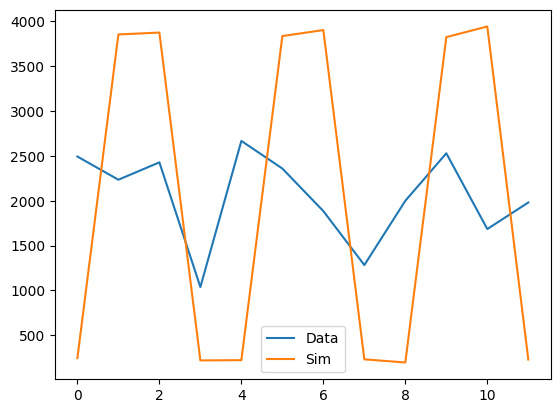

In [72]:
plt.plot(qubit_vals(results.get_counts(0),2,3),label="Data")
plt.plot(qubit_vals(results_sim.get_counts(0),2,3),label="Sim")
plt.legend()

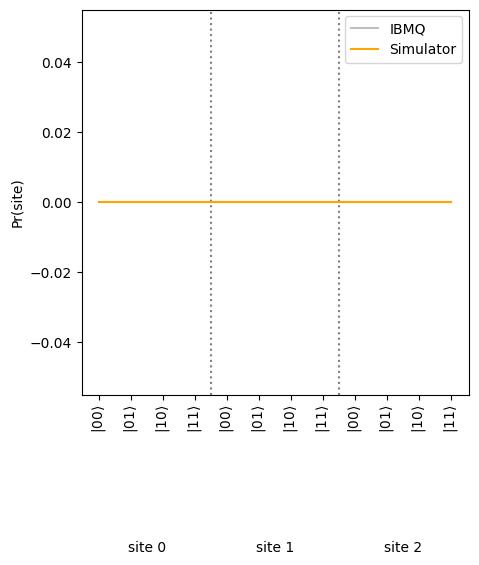

In [97]:
plot_persite_combined([qubit_vals(results.get_counts(0),2,3),qubit_vals(results_sim.get_counts(0),2,3)],
                      QC_nQ, QC_nL, ["IBMQ","Simulator"], [False,False])

In [94]:
def plot_persite_combined(result,nQ,nL,mylabels,doreverse):
    '''
    result is a list of lists of probabilities for the 2^(nQ*nL) states.  For example, if have only one prediction, then result will be [[Pr(000..000),Pr(000..001),...]].
    #nQ is the number of qubits per lattice site
    #nL is the number of lattice sites
    #mylabels is an array of labels for each element in result.
    #doreverse is an array of booleans for each element in result.  Qiskit results should have True while everything else should have False (Qiskit labels states "backwards")

    '''

    f = plt.figure(figsize=(5,5))
    plt.ylabel("Pr(site)")

    xlabs = []
    for i in range(nL):
        plt.text(2**nQ*i+2**nQ/2-0.5,-0.1,"site "+str(i),horizontalalignment='center')
        if (i > 0):
            plt.axvline(2**nQ*i-0.5,color='grey',ls=":")
        for j in range(2**nQ):
            xlabs += [r'$|'+bin(j)[2:].zfill(nQ)+r'\rangle$']
            pass
        pass

    forplot = np.zeros([nL*2**nQ,len(result)])
    for k in range(len(result)):
        for i in range(nL):
            for j in range(2**(nQ*nL)):
                qval = int(gmpy2.digits(j,2**nQ).zfill(nL)[i])
                if j in result[k]:
                    forplot[qval+i*2**nQ,k]+=result[k][j]
                    pass
                pass
            pass
        pass
    plt.xticks(range(nL*2**nQ),xlabs,rotation='vertical',fontsize=10,horizontalalignment='center')

    mycolors = ["grey","orange","black"]
    mylinestyles = ["-","-",":"]
    myalphas = [0.5,1,1]
    for k in range(3,len(result)):
        mycolors+=["black"]
        mylinestyles+=[":"]
        myalphas+=[1.]
        pass
    
    for k in range(len(result)):
        if (doreverse[k]):
            plt.plot(forplot[:,k][::-1],label=mylabels[k],color=mycolors[k],ls=mylinestyles[k],alpha=myalphas[k]) #annoyingly, Qiskit counts backwards
        else:
            plt.plot(forplot[:,k],label=mylabels[k],color=mycolors[k],ls=mylinestyles[k],alpha=myalphas[k])
            pass
        pass
    plt.legend()


In [96]:
import gmpy2